### Autoregressive RNN With Softmax on Alanine Dipeptide

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.distributions as dist
import torch.optim as optim

from torch.utils.data import DataLoader
import sys
import os

In [2]:
## load required modules
## load MMCDataset class
## MMCD_path = "/path/to/MMCD"
MMCD_path = "./"
sys.path.append(MMCD_path)
from mmcd import MMCDataset

name = 'dialanine'
data_path = os.path.join(MMCD_path, "data")

dataset_train = MMCDataset(root = data_path,
                           molecule_name = name,
                           train = True,
                           coordinate_type = 'internal',
                           lazy_load = False)

train_loader = DataLoader(dataset_train,
                          num_workers = 1,
                          batch_size = 256, #256 is the default batch size
                          shuffle = True)

In [3]:
def flatten_data(data):
    """
    Input: data is a single dictionary item. In this case, for dialanine, it is a dictionary item 
    with six keys, each referencing a torch.tensor of size [256, 256, 256, (256, 19),(256, 19), (256, 19)]
    respectively. The batch size is 256, so the batch data is size [256, 256, 256, (256, 19), (256, 19), 
    (256, 19)]. Each dialiene molecule is  size [1, 1, 1, 19, 19, 19].
    
    Output: the dictionary item flattened into a 1-D tensor. It is a 1-D tensor of size 60
    for dialanine. We want a length 256 data object where each item is a 60-length 1-d tensor
    The resulting data object has shape: torch.Size of [256, 60].
    """
    result = torch.cat(
        [data['reference_particle_2_bond'][:, None],
         data['reference_particle_3_bond'][:, None],
         data['reference_particle_3_angle'][:, None],
         data['bond'], data['angle'], data['dihedral']],
        dim = -1)

    return result

def extract_ramachandran(data):
    result = torch.cat(
        [data['reference_particle_2_bond'][:, None],
         data['reference_particle_3_bond'][:, None],
         data['reference_particle_3_angle'][:, None],
         data['bond'], data['angle'], data['dihedral']],
        dim = -1)

    return result[:, [43,45]]

def rebuild(flat, data_length = 19):
    """
    Input: flattened tensor of torch.Size [256, 60], rebuild and return
    the original molecule, a dictionary item. The inverse of the flatten_data function.
    """
    data_length = 19 #this is particular to dialene
    result = {}

    result['reference_particle_1_xyz'] = torch.zeros((flat.shape[0], 3))
    result['reference_particle_2_bond'] = flat[:, 0]
    result['reference_particle_3_bond'] = flat[:, 1]
    result['reference_particle_3_angle'] = flat[:, 2]

    start = 3
    end = start + data_length
    result['bond'] = flat[:, start:end]

    start = end
    end = start + data_length
    result['angle'] = flat[:, start:end]

    start = end
    end = start + data_length
    result['dihedral'] = flat[:, start:end]

    return result

In [4]:
def number_to_vec(ic, num_decimals = 2):
    """
    [1.80, 1.84, 0.97] -> [180, 184, 097]
    """
    ic = torch.trunc(100*ic)
    ic = ic/100

    indicies = ic * 10**num_decimals + 314
    indicies = indicies.long()
    num_of_classes = 2 * 3.14 * 10**num_decimals + 1
    one_hots = F.one_hot(indicies, num_classes = int(num_of_classes))

    return one_hots

def number_to_vec_class(ic, num_decimals = 2):
    ic = torch.trunc(100*ic)
    ic = ic/100

    indicies = ic * 10**num_decimals + 314
    indicies = indicies.long()

    return indicies

def index_to_number(ic, num_decimals = 2):
    ic = ic.float()
    return (ic-314)/100

def vec_to_number(one_hots, num_decimals = 2):
    labels_again = (torch.argmax(one_hots, dim=2) -314)/100 #replace with dim=2 once u get it going
    return labels_again

In [44]:
class InternalCoordinateSoftmaxJordanRNNv2(nn.Module):
    def __init__(self, batch_size = 256):
        super(InternalCoordinateSoftmaxJordanRNNv2, self).__init__()
        
        self.batch_size = 256
        self.hidden_size = 10
        self.steps = 2
        
        #Modules for everything that is not the first input.
        self.hidden_to_energy = nn.ModuleList([nn.Linear(10, 629) for index in range(20)]) #Energy
        self.energy_to_hidden = nn.ModuleList([nn.Linear(629, 10) for index in range(20)])
        self.x_to_hidden = nn.ModuleList([nn.Linear(1, 10) for index in range(20)])

        self.activation_function = torch.nn.Softmax(dim=1)
        self.loss_function = nn.CrossEntropyLoss()

    def forward(self, X):  
        h = torch.zeros(X.size()[0], self.hidden_size, 1).to(device) #[256, number_of_bins = 628, 1]
        energy = self.hidden_to_energy[0](h[:, :, 0]) #[256, 628, 1]
        energy = torch.unsqueeze(energy, dim=2)

        for index in range(1, self.steps, 1): #Recall generating the 0th item, so generate 18 more items

            x_t = X[:, index-1:index] 
            energy_t_minus_1 = energy[:, :, index-1]  

            a = self.x_to_hidden[index](x_t.float()) 
            b = torch.relu( self.energy_to_hidden[index](energy_t_minus_1)/1000 ) #this index!!!

            new_h = torch.relu( a ) # + b ) #size = [256, 10, 1]
            
            new_energy = self.hidden_to_energy[index](new_h)
            
            new_energy = torch.unsqueeze(new_energy, dim = 2)
            new_h = torch.unsqueeze(new_h, dim = 2)

            h = torch.cat([h, new_h], dim = 2)
            energy = torch.cat([energy, new_energy], dim = 2)

        return h, energy

    '''h = torch.zeros(X.size()[0], self.hidden_size, 1).to(device) #[256, number_of_bins = 628, 1]
        energy = self.hidden_to_energy[0](h[:, :, 0]) #[256, 628, 1]
        energy = torch.unsqueeze(energy, dim=2)

        categorical = self.activation_function(energy)
        temp_distribution = dist.Categorical(categorical)
        
        X = temp_distribution.sample()
        X = X.unsqueeze(dim = 1) #[num_samples, 1]
        #print(energy.size())'''

    
    def sample(self, num_samples = 256):
        h = torch.zeros(num_samples, self.hidden_size, 1).to(device) #[256, number_of_bins, 1]
        energy = self.hidden_to_energy[0](h[:, :, 0])
        categorical = self.activation_function(energy)
        temp_distribution = dist.Categorical(categorical)
        X = temp_distribution.sample()
        X = X.unsqueeze(dim = 1) #[num_samples, 1]
        energy = energy.unsqueeze(dim = 2)
        #print(energy.size())

        for index in range(1, self.steps, 1): #Recall generating the 0th item, so generate 18 more items
            
            #print(index)

            x_t = X[:, index-1:index] 
            energy_t_minus_1 = energy[:, :, index-1]  

            a = self.x_to_hidden[index](x_t.float()) 
            b = torch.relu(self.energy_to_hidden[index](energy_t_minus_1)/1000)

            new_h = torch.relu( a )#+ ) b ) #size = [256, 10, 1]
            new_energy = self.hidden_to_energy[index](new_h)

            temp_categorical = self.activation_function(new_energy) 
            temp_distribution = dist.Categorical(categorical)
            new_x = temp_distribution.sample()
            
            new_energy = torch.unsqueeze(new_energy, dim = 2)
            new_h = torch.unsqueeze(new_h, dim = 2)

            h = torch.cat([h, new_h], dim = 2)
            energy = torch.cat([energy, new_energy], dim = 2)
            X = torch.cat([X, new_x.unsqueeze(dim=1)], dim = 1)

        return h, X

    def loss(self, X, Y, tensor_form = False):
        #X is a categorical distribution and Y is the target (one hot encoding).
        #this one gave me AIDs to solve
        #https://discuss.pytorch.org/t/cross-entropy-loss-for-a-sequence-time-series-of-output/4309
        #X = [256, 628, 19]
        #Y = [256, 19]
        Y = Y.permute(1, 0)
        X = X.permute(2, 0, 1)

        #X = [19, 256, 628]
        #Y = [19, 256]

        X = torch.flatten(X, start_dim=0, end_dim=1) 
        Y = torch.flatten(Y)   

        #print(X.size())
        #print(Y.size())
        
        loss_value = self.loss_function(X, Y)
        return loss_value        

device = torch.device("cuda")
model = InternalCoordinateSoftmaxJordanRNNv2().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-3)  #lr is step size, arbitrarily picked.

### Training Loop

In [45]:
loss_over_time = []

def train(epoch):
    model.train()
    train_loss = 0

    for batch_idx, (data, _) in enumerate(train_loader):
        #Flatten the data into a tensor of size (256, 60) tensor before putting it into the GPU
        data = flatten_data(data)
        data = number_to_vec_class(data[:, 41:43])

        true_target = data
        true_target = true_target.to(device)

        optimizer.zero_grad()

        h, X_pred = model(true_target) #h is the hidden layers, but it is useless

        loss = model.loss(X = X_pred, Y = true_target)
        
        loss.backward()

        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:#args.log_interval == 0: #by default, args.log_interval = 10
            print('Train Epoch:', epoch, '[{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(

                #len(train_loader) should be 625
                batch_idx, #index of the batch we are on 
                len(train_loader), #how many batches are in the data loader
                100. * batch_idx / len(train_loader), #progress percentage
                loss.item() / len(train_loader))  #hardcoded batch size
                )
        
            loss_over_time.append(loss.item()/len(train_loader) )

for epoch in range(0, 10, 1):
    train(epoch)

    '''
    sample =  model.sample(1000)
    sample = rebuild(sample)
    potential_energy_q_theta = dataset_train.compute_potential_energy_for_ic(sample)
    print(np.sum(potential_energy_q_theta)/1000)
    '''

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4a67d65af0>
Traceback (most recent call last):
  File "/home/jared/anaconda3/envs/MMCD/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/jared/anaconda3/envs/MMCD/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/jared/anaconda3/envs/MMCD/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    

Train Epoch: 0 [0/625 (0%)]	Loss: 0.155077


assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Train Epoch: 0 [100/625 (16%)]	Loss: 0.019713
Train Epoch: 0 [200/625 (32%)]	Loss: 0.008349
Train Epoch: 0 [300/625 (48%)]	Loss: 0.007409
Train Epoch: 0 [400/625 (64%)]	Loss: 0.006930
Train Epoch: 0 [500/625 (80%)]	Loss: 0.006741
Train Epoch: 0 [600/625 (96%)]	Loss: 0.006568


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4a67d65af0>
Traceback (most recent call last):
  File "/home/jared/anaconda3/envs/MMCD/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/jared/anaconda3/envs/MMCD/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/jared/anaconda3/envs/MMCD/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Train Epoch: 1 [0/625 (0%)]	Loss: 0.006577
Train Epoch: 1 [100/625 (16%)]	Loss: 0.006333
Train Epoch: 1 [200/625 (32%)]	Loss: 0.006315
Train Epoch: 1 [300/625 (48%)]	Loss: 0.006163
Train Epoch: 1 [400/625 (64%)]	Loss: 0.006151
Train Epoch: 1 [500/625 (80%)]	Loss: 0.005974
Train Epoch: 1 [600/625 (96%)]	Loss: 0.006024


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4a67d65af0>
Traceback (most recent call last):
  File "/home/jared/anaconda3/envs/MMCD/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/jared/anaconda3/envs/MMCD/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/jared/anaconda3/envs/MMCD/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Train Epoch: 2 [0/625 (0%)]	Loss: 0.005903
Train Epoch: 2 [100/625 (16%)]	Loss: 0.005931
Train Epoch: 2 [200/625 (32%)]	Loss: 0.005768
Train Epoch: 2 [300/625 (48%)]	Loss: 0.005904
Train Epoch: 2 [400/625 (64%)]	Loss: 0.005749
Train Epoch: 2 [500/625 (80%)]	Loss: 0.005772
Train Epoch: 2 [600/625 (96%)]	Loss: 0.005980


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4a67d65af0>
Traceback (most recent call last):
  File "/home/jared/anaconda3/envs/MMCD/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/jared/anaconda3/envs/MMCD/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/jared/anaconda3/envs/MMCD/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Train Epoch: 3 [0/625 (0%)]	Loss: 0.005704
Train Epoch: 3 [100/625 (16%)]	Loss: 0.005776
Train Epoch: 3 [200/625 (32%)]	Loss: 0.005774
Train Epoch: 3 [300/625 (48%)]	Loss: 0.005630
Train Epoch: 3 [400/625 (64%)]	Loss: 0.005667
Train Epoch: 3 [500/625 (80%)]	Loss: 0.005625
Train Epoch: 3 [600/625 (96%)]	Loss: 0.005720


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4a67d65af0>
Traceback (most recent call last):
  File "/home/jared/anaconda3/envs/MMCD/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/jared/anaconda3/envs/MMCD/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/jared/anaconda3/envs/MMCD/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Train Epoch: 4 [0/625 (0%)]	Loss: 0.005785
Train Epoch: 4 [100/625 (16%)]	Loss: 0.005654
Train Epoch: 4 [200/625 (32%)]	Loss: 0.005759
Train Epoch: 4 [300/625 (48%)]	Loss: 0.005622
Train Epoch: 4 [400/625 (64%)]	Loss: 0.005704


KeyboardInterrupt: 

33


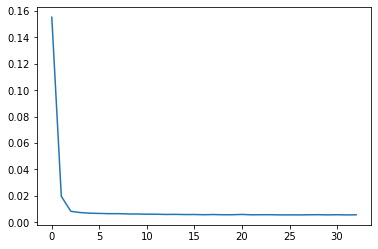

In [46]:
ls = np.array(loss_over_time)
print(np.size(ls))
plt.plot(ls)

### Sample From Model to View Distribtuions

In [47]:
sample_loader = DataLoader(dataset_train,
                          num_workers = 4,
                          batch_size = 5000, #256 is the default batch size
                          shuffle = True)

for batch_idx, (data, _) in enumerate(sample_loader):
    data = flatten_data(data)
    np_data = np.array(data)
    break

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4a67d65af0>
Exception ignored in: Traceback (most recent call last):
  File "/home/jared/anaconda3/envs/MMCD/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f4a67d65af0>    
Traceback (most recent call last):
Exception ignored in: self._shutdown_workers()  File "/home/jared/anaconda3/envs/MMCD/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/jared/anaconda3/envs/MMCD/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4a67d65af0><function _MultiProcessingDataLoaderIter.__del__ at 0x7f4a67d65af0>


  File "/home/jared/anaconda3/envs/MMCD/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_work

In [38]:
categorical, samples = model.sample(5000)

In [48]:
samples = index_to_number(samples)

In [49]:
np_samples = np.array(samples.cpu().detach())

### Dihedrals

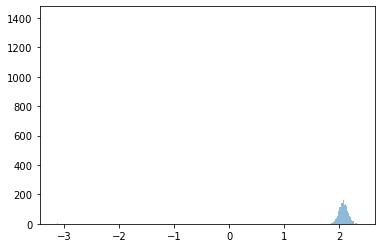

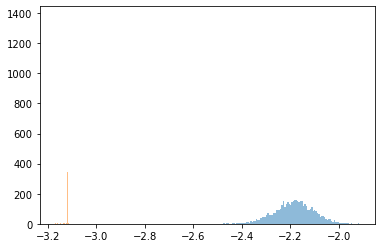

In [51]:
for index in range(0, 2, 1):
    plt.hist(np_data[:, index+41], label = "$p_A(x)$",bins = 100, alpha = 0.5)
    plt.hist(np_samples[:, index], bins = 100, alpha=0.5)
    plt.show()